In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, \
                            r2_score, mean_absolute_error

In [76]:
dataset = pd.read_csv('bitcoin_new.csv')

In [77]:
dataset.head()

,Date,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,SMA_30,Lag_1,Lag_2,Lag_3,Lag_7,Volatility_7,Day_of_Week
0,2016-01-31,369.8,-8.0,5.912962,-0.021403,383.600000,410.170000,377.8,380.3,379.7,402.1,9.158057,6
1,2016-02-01,372.2,2.4,5.919431,0.006469,380.657143,408.120000,369.8,377.8,380.3,392.8,9.017734,0
2,2016-02-02,373.9,1.7,5.923988,0.004557,378.385714,406.226667,372.2,369.8,377.8,389.8,8.305305,1
3,2016-02-03,368.0,-5.9,5.908083,-0.015905,374.528571,404.050000,373.9,372.2,369.8,395.0,4.857199,2
4,2016-02-04,390.6,22.6,5.967684,0.059601,376.085714,402.696667,368.0,373.9,372.2,379.7,7.704204,3


In [78]:
tstart = '2016-01-08'
tend = '2023-03-01'

In [79]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)


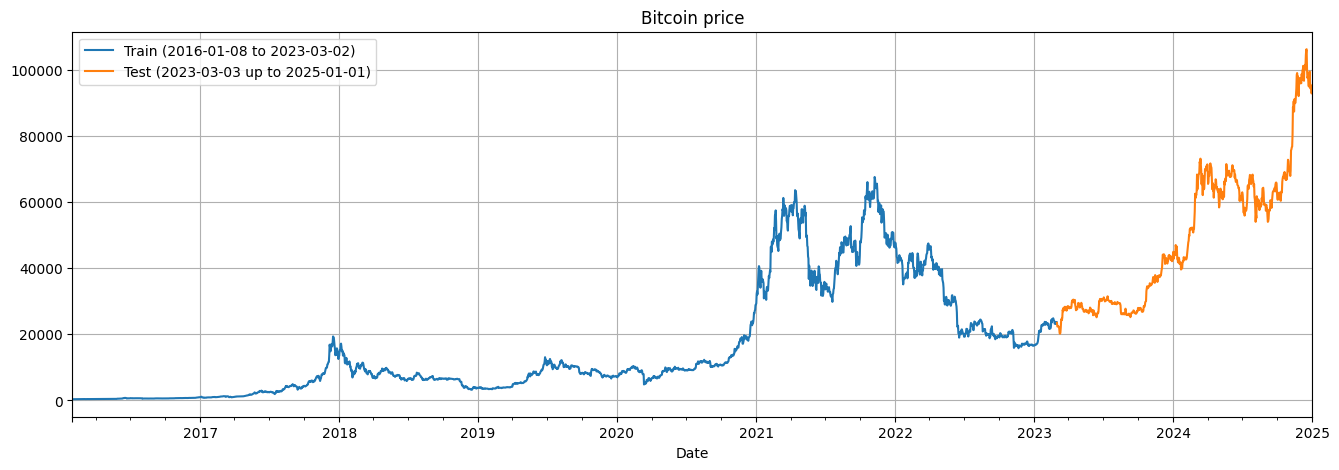

In [80]:
def train_test_plot(dataset, tstart, tend):
    tstart = pd.to_datetime(tstart)
    tend = pd.to_datetime(tend)
    tend_next = tend + pd.Timedelta(days=1)

    dataset.loc[tstart:tend, "Price"].plot(figsize=(16, 5), legend=True)
    dataset.loc[tend_next:, "Price"].plot(figsize=(16, 5), legend=True)

    plt.legend([f"Train (2016-01-08 to {tend_next.date()})", f"Test ({tend_next.date() + pd.Timedelta(days=1)} up to 2025-01-01)"])
    plt.title("Bitcoin price")
    plt.grid()
    plt.show()

train_test_plot(dataset, tstart, tend)

In [81]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "Price"].values
    test = dataset.loc[tend_next:, "Price"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [82]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)
     

In [83]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [84]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [85]:
# Reshape X_train to 2D
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

model = RandomForestRegressor()
model.fit(X_train_reshaped, y_train)

c:\Users\maria\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [86]:
dataset_total = dataset.loc[:, "Price"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * features)
#prediction
predicted_stock_price = model.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))
     

In [93]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [88]:
def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    r2 = r2_score(test, predicted)
    msle = mean_squared_log_error(test, predicted)
    mape = np.mean(np.abs((test - predicted) / test)) * 100
    
    print(f"The root mean squared error is {rmse:.2f}")
    print(f"The Mean Absolute Error (MAE) is {mae:.2f}")
    print(f"The R-squared (R²) score is {r2:.4f}\n")
    print(f"The Mean Squared Logarithmic Error (MSLE) is {msle:.6f}")
    print(f"The Mean Absolute Percentage Error (MAPE) is {mape:.2f}%.")
     

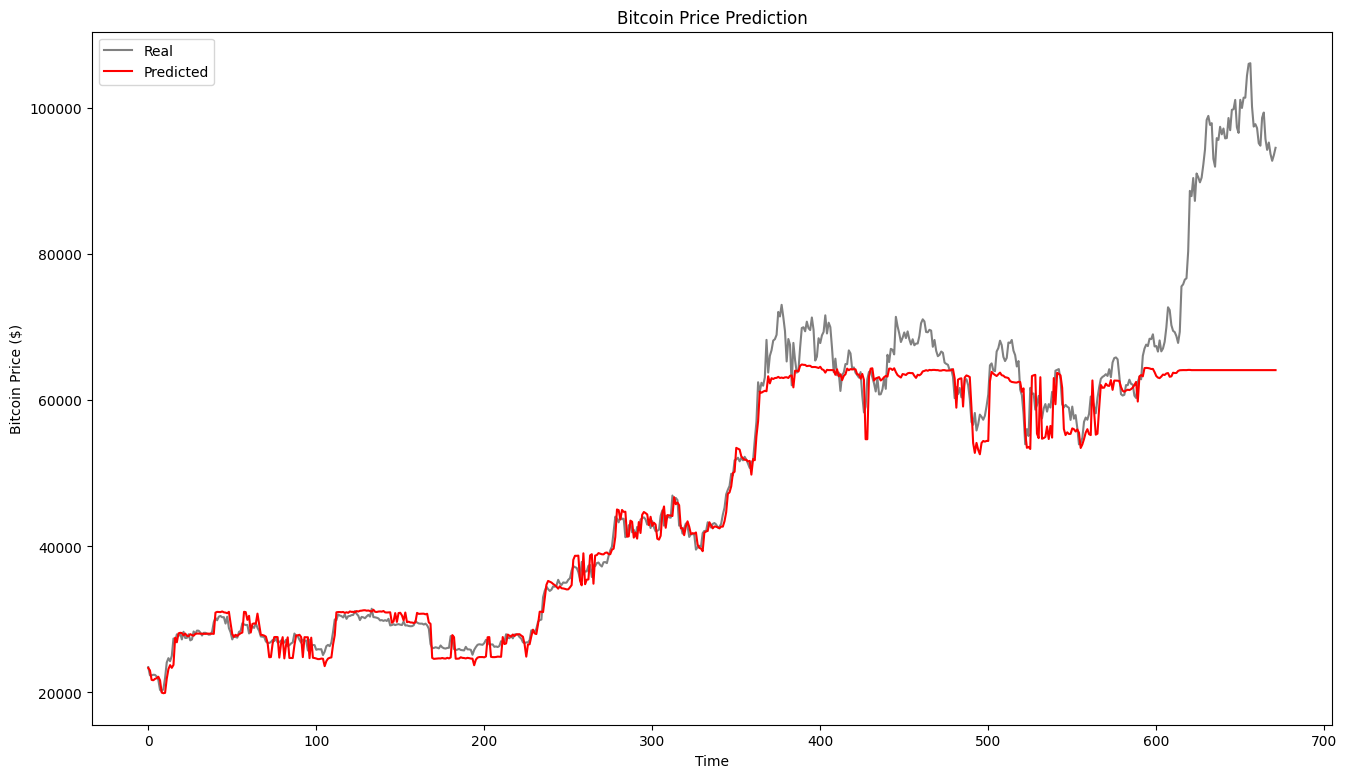

In [94]:
plot_predictions(test_set, predicted_stock_price)

In [90]:
evaluate_model(test_set, predicted_stock_price)

The root mean squared error is 9433.99
The Mean Absolute Error (MAE) is 4325.97
The R-squared (R²) score is 0.8016

The Mean Squared Logarithmic Error (MSLE) is 0.015387
The Mean Absolute Percentage Error (MAPE) is 47.60%.
